# Million Songs Dataset
Processing & cleaning

1. [Artist Similarity](#0)

2. [Artist MB Tag](#1)

1. [Artist Terms](#Artist-Term)

2. [Song Metadata](#3)

1. [Track Analysis](#4)

2. [Track Metadata](#5)

1. [Aggregation](#6)
    1. [Artist Terms & Artist MB Tags](#A)
    2. [Track Metadata & Song Metadata](#B) 
    3. [Meta Merge](#C)   
    4. [Main DF & Optimization](#D)
1. [Downcasting](#7)

2. [Pickling](#8)

In [1]:
import pandas as pd
import os
import sys
import time
import glob
import datetime
import sqlite3
import numpy as np
import json
import pickle
import re
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint as pp
from sqlalchemy import create_engine
#cnx = create_engine('postgresql://user: @<ip>:<port>/user')


%matplotlib inline
sns.set()
sns.set_palette('Set1')
pd.options.display.max_rows = 1000
pd.set_option('precision', 5)

!pwd # /Users/user/Documents/Metis/McNulty/MSD

/Users/user/Documents/Metis/McNulty/MSD


### Data Load

In [2]:
dfs_names = ['artist_similarity', 'artist_mbtag', 'artist_term', 
             'song_metadata_hdf5', 'track_analysis', 'track_metadata']

csv_path='csv/converted_files/'
csv_files = os.listdir(csv_path)

csv_files

['CONVERTED_artist_similarity||similarity.csv',
 'CONVERTED_artist_term||artist_mbtag.csv',
 'CONVERTED_artist_term||artist_term.csv',
 'CONVERTED_song_metadata.csv',
 'CONVERTED_track_analysis.csv',
 'CONVERTED_track_metadata||songs.csv',
 'CONVERTED_tracks_per_year.csv',
 'CONVERTED_unique_artists.csv',
 'CONVERTED_unique_tracks.csv']

In [3]:
# Loading dataframes from csv files
def csv_to_df(path, file):
    if file != '.DS_Store':
        return pd.read_csv(path + file)

artist_similarity_df = csv_to_df(csv_path, csv_files[0])
artist_mbtag_df = csv_to_df(csv_path, csv_files[1])
artist_term_df = csv_to_df(csv_path, csv_files[2])
song_metadata_hdf5_df = csv_to_df(csv_path, csv_files[3])
track_analysis_df = csv_to_df(csv_path, csv_files[4])
track_metadata_df = csv_to_df(csv_path, csv_files[5])

dfs = \
[artist_similarity_df
,artist_mbtag_df
,artist_term_df
,song_metadata_hdf5_df
,track_analysis_df
,track_metadata_df]

# Dimensions of all dfs
shapes = [i.shape for i in dfs]
list(zip(dfs_names, shapes))

[('artist_similarity', (2201916, 2)),
 ('artist_mbtag', (24777, 2)),
 ('artist_term', (1109381, 2)),
 ('song_metadata_hdf5', (1000000, 16)),
 ('track_analysis', (1000000, 14)),
 ('track_metadata', (1000000, 11))]

In [4]:
list(zip(dfs_names,shapes))

[('artist_similarity', (2201916, 2)),
 ('artist_mbtag', (24777, 2)),
 ('artist_term', (1109381, 2)),
 ('song_metadata_hdf5', (1000000, 16)),
 ('track_analysis', (1000000, 14)),
 ('track_metadata', (1000000, 11))]

### <a id=0></a> Artist Similarity

In [5]:
# Not used
artist_similarity_df.head(2)

,target,similar
0,AR002UA1187B9A637D,ARQDOR81187FB3B06C
1,AR002UA1187B9A637D,AROHMXJ1187B989023


### <a id=1></a> Artist MB Tag

In [6]:
artist_mbtag_df.info()
artist_mbtag_df = pd.get_dummies(artist_mbtag_df, columns=["mbtag"], prefix="tag")
cols = [c for c in artist_mbtag_df.columns if len(c)<60]

artist_mbtag_df=artist_mbtag_df[cols]
artist_mbtag_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24777 entries, 0 to 24776
Data columns (total 2 columns):
artist_id    24777 non-null object
mbtag        24777 non-null object
dtypes: object(2)
memory usage: 387.2+ KB


,artist_id,tag_00s,tag_00s 10s,tag_1 7 186240 183 23558 41608 89158 111733 150833 169883,tag_10s,tag_1960s,tag_1970s,tag_1980s,tag_1989,tag_1990s,...,tag_éire,tag_ísland,tag_örebro,tag_л федоров,tag_ਪੰਜਾਬੀ,tag_ਭੰਗੜਾ,tag_ハロー プロジェクト,tag_姚姓,tag_日本,tag_香港歌手
0,AR002UA1187B9A637D,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AR002UA1187B9A637D,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AR002UA1187B9A637D,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AR006821187FB5192B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AR00A6H1187FB5402A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Artist Term

In [7]:
artist_term_df.replace(to_replace=['emotional', 'discover'], value='other', inplace=True)

artist_term_df.head(3)

,artist_id,term
0,AR002UA1187B9A637D,garage rock
1,AR002UA1187B9A637D,country rock
2,AR002UA1187B9A637D,free jazz


In [8]:
# Explore unique genres
print('Unique groups of genres: ', artist_term_df.groupby('term')['artist_id'].ngroups)
# 7,642 genres to collapse

genres_df = (artist_term_df.groupby('term')['artist_id']
                           .nunique()
                           .sort_values(ascending=False)
                           .to_frame()
                           .reset_index())

Unique groups of genres:  7642


In [9]:
# Swap rock out to explore anything %LIKE%
#genres_df[genres_df.term.str.contains("rock")]

In [10]:
def term_grouping(terms, label):
    artist_term_df.at[artist_term_df.loc[:,'term'].str.contains(r'({})'.format(terms)), 'term'] = '{}'.format(label)

term_grouping(r'(country)', 'country')
term_grouping(r'(blues|jazz|bossa)', 'jazz')
term_grouping(r'(metal|screamo|death)', 'metal')
term_grouping(r'(reggae)', 'reggae')
term_grouping(r'(rap|freestyle|hop|r&b)', 'hiphop')
term_grouping(r'(garage|punk|ska|grunge|emo)', 'punk')
term_grouping(r'(pop)', 'pop')
term_grouping(r'(electro|trance|techno|house|ebm|glitch|tronic|dance|step|dj|synth|drum and bass|club)', 'electronic')
term_grouping(r'(rock)', 'rock')
term_grouping(r'(indie|alternative)', 'alternative')
term_grouping(r'(folk|grass)', 'folk')
term_grouping(r'(funk|soul|disco)', 'funk')
artist_term_df.replace(to_replace=['electric'], value='electronic', inplace=True)

artist_term_df['term'][~artist_term_df.term.str.contains("country|jazz|metal|reggae|hiphop|punk|pop|electronic|rock|alternative|folk|funk")] = 'other'


/Users/user/Desktop/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


Unique groups of genres:  13


/Users/user/Desktop/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


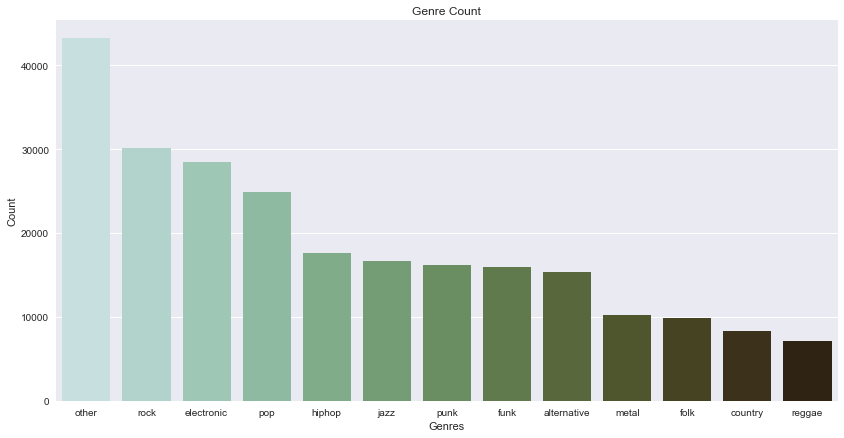

In [11]:
# Explore new unique genres
print('Unique groups of genres: ', artist_term_df.groupby('term')['artist_id'].ngroups)

genres_df = (artist_term_df.groupby('term')['artist_id']
                           .nunique()
                           .sort_values(ascending=False)
                           .to_frame()
                           .reset_index())

fig = plt.figure()
fig.set_size_inches(14, 7)
bar = sns.barplot(x='term', y='artist_id', data = genres_df,
                  palette=sns.cubehelix_palette(13, start=1, rot=.55))
bar.set(xlabel='Genres', ylabel='Count', title="Genre Count");

In [12]:
# Creating genre labels and setting to binary for each artist
artist_term_df = pd.get_dummies(artist_term_df, columns=["term"], 
                                prefix_sep='', prefix='')
artist_term_df = artist_term_df.groupby('artist_id').sum()
artist_term_df = artist_term_df.applymap(lambda x: True if x>0 else False)
artist_term_df = artist_term_df.astype('int8').reset_index()
artist_term_df.head(3)

,artist_id,alternative,country,electronic,folk,funk,hiphop,jazz,metal,other,pop,punk,reggae,rock
0,AR002UA1187B9A637D,0,1,1,0,0,0,1,0,1,1,1,1,1
1,AR003FB1187B994355,0,0,0,0,0,1,0,0,1,1,1,0,1
2,AR006821187FB5192B,0,1,1,1,0,0,0,1,1,1,0,1,1


### <a id="3"></a> Song Metadata

In [13]:
# Replace with other artist scores
'''columns_temp = ['artist_familiarity', 'artist_hotttnesss']
for col in columns_temp:
    song_metadata_hdf5_df[f'{col}'].fillna(song_metadata_hdf5_df.groupby('artist_id')[f'{col}'] \
                        .transform('mean'), inplace=True)''';

# Fill null values
song_metadata_hdf5_df.artist_latitude.fillna(value=-9999, inplace=True)
song_metadata_hdf5_df.artist_longitude.fillna(value=-9999, inplace=True)
song_metadata_hdf5_df.song_hotttnesss.fillna(value=-9, inplace=True)

song_metadata_hdf5_df.drop(labels=['artist_7digitalid', 'artist_playmeid',
                                   'release_7digitalid','track_7digitalid',
                                   'release', 'artist_location', 'title',
                                   'artist_familiarity', 'artist_hotttnesss'], 
                           axis=1, inplace=True)

print(song_metadata_hdf5_df.info())
#song_metadata_hdf5_df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 7 columns):
song_id             1000000 non-null object
artist_id           1000000 non-null object
artist_latitude     1000000 non-null float64
artist_longitude    1000000 non-null float64
artist_mbid         937429 non-null object
artist_name         1000000 non-null object
song_hotttnesss     1000000 non-null float64
dtypes: float64(3), object(4)
memory usage: 53.4+ MB
None


In [14]:
song_metadata_hdf5_df.nunique()

song_id             999056
artist_id            44745
artist_latitude       2664
artist_longitude      2667
artist_mbid          38729
artist_name          72665
song_hotttnesss     113198
dtype: int64

### <a id=4></a> Track Analysis

In [15]:
track_analysis_df.drop(labels=['danceability', 'energy', 'key_confidence'], 
                       axis=1, inplace=True)

# Flawed feature
'''def conf_nozeroes(x):
    if x<0.1:
        return x + 0.0001
    
track_analysis_df.key_confidence = track_analysis_df.key_confidence.map(conf_nozeroes)
track_analysis_df['key_adj'] = track_analysis_df.key_confidence.apply(lambda x: np.log(1/x)) 
track_analysis_df['key_lw'] = track_analysis_df.key - track_analysis_df.key_adj
track_analysis_df['key_up'] = track_analysis_df.key + track_analysis_df.key_adj'''

print(track_analysis_df.info())
track_analysis_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 11 columns):
track_id                     1000000 non-null object
duration                     1000000 non-null float64
end_of_fade_in               1000000 non-null float64
key                          1000000 non-null int64
loudness                     1000000 non-null float64
mode                         1000000 non-null int64
mode_confidence              1000000 non-null float64
start_of_fade_out            1000000 non-null float64
tempo                        1000000 non-null float64
time_signature               1000000 non-null int64
time_signature_confidence    1000000 non-null float64
dtypes: float64(7), int64(3), object(1)
memory usage: 83.9+ MB
None


,duration,end_of_fade_in,key,loudness,mode,mode_confidence,start_of_fade_out,tempo,time_signature,time_signature_confidence
count,1000000.00000,1000000.00000,1000000.00000,1000000.00000,1000000.00000,1000000.00000,1000000.00000,1000000.00000,1000000.00000,1000000.00000
mean,249.50075,0.81985,5.32196,-10.12404,0.66641,0.47211,240.62502,123.88922,3.59395,0.51592
std,126.22964,3.30446,3.60160,5.19724,0.47150,0.19261,124.07992,35.05598,1.22193,0.37190
min,0.31302,0.00000,0.00000,-58.17800,0.00000,0.00000,0.31300,0.00000,0.00000,0.00000
25%,180.74077,0.00000,2.00000,-12.67200,0.00000,0.35600,173.18000,97.99500,3.00000,0.12500
50%,228.85832,0.19400,5.00000,-8.96300,1.00000,0.48300,219.75900,122.08600,4.00000,0.55700
75%,289.93261,0.43200,9.00000,-6.38600,1.00000,0.60200,279.71300,144.08900,4.00000,0.86900
max,3034.90567,1163.94100,11.00000,4.31800,1.00000,1.00000,3030.62200,302.30000,7.00000,1.00000


### <a id=5></a> Track Metadata

In [16]:
print(track_metadata_df.info())
print(track_metadata_df.head(1))
track_metadata_df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 11 columns):
track_id              1000000 non-null object
title                 999985 non-null object
song_id               1000000 non-null object
release               999995 non-null object
artist_id             1000000 non-null object
artist_mbid           937429 non-null object
artist_name           1000000 non-null object
duration              1000000 non-null float64
artist_familiarity    1000000 non-null float64
artist_hotttnesss     1000000 non-null float64
year                  1000000 non-null int64
dtypes: float64(3), int64(1), object(7)
memory usage: 83.9+ MB
None
             track_id         title             song_id  \
0  TRMMMYQ128F932D901  Silent Night  SOQMMHC12AB0180CB8   

                 release           artist_id  \
0  Monster Ballads X-Mas  ARYZTJS1187B98C555   

                            artist_mbid       artist_name   duration  \
0  357ff05d-848a-44cf-b608-

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year
count,1000000,999985,1000000,999995,1000000,937429,1000000,1000000.00000,1000000.00000,1000000.00000,1000000.00000
unique,1000000,702428,999056,149288,44745,38729,72665,NaN,NaN,NaN,NaN
top,TRKJGJZ128F933D896,Intro,SOLNCTS12A8C1405EF,Greatest Hits,AR6681Y1187FB39B02,1c7b3786-b99a-40ab-81e4-f3056da19e13,Michael Jackson,NaN,NaN,NaN,NaN
freq,1,1510,3,2014,208,208,194,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,249.50075,0.55692,0.37980,1030.32565
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,126.22964,0.14021,0.12605,998.74500
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.31302,-1.00000,-1.00000,0.00000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.74077,0.47822,0.33632,0.00000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,228.85832,0.55888,0.38619,1969.00000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,289.93261,0.64139,0.44407,2002.00000


# <a id=6></a>Aggregation

### <a id="A"></a>Artist Term & Artist MB Tags

In [17]:
# Joining artist term and musicbrainz tags
termtag_df = pd.merge(artist_term_df, artist_mbtag_df, on='artist_id', how='outer', suffixes=('_1', '_2'))
termtag_df.set_index('artist_id', inplace=True)
termtag_df.fillna(value=0, inplace=True)

# Remove any zero sum rows
termtag_df = termtag_df.astype('int8')
mask = termtag_df.sum(axis=1) == 0
termtag_df = termtag_df[~mask]
termtag_df.reset_index(inplace=True)

# Count duplicates
print("Row duplicates:", termtag_df.duplicated(subset=['artist_id']).sum())

# Explore duplicates
termtag_df.sort_values(['artist_id'], inplace=True, ascending=False)
termtag_df.loc[termtag_df.duplicated(subset=['artist_id'], keep=False)].head(8)

Row duplicates: 15939


,artist_id,alternative,country,electronic,folk,funk,hiphop,jazz,metal,other,...,tag_éire,tag_ísland,tag_örebro,tag_л федоров,tag_ਪੰਜਾਬੀ,tag_ਭੰਗੜਾ,tag_ハロー プロジェクト,tag_姚姓,tag_日本,tag_香港歌手
59876,ARZZYRB1187B99D0B6,0,0,1,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
59875,ARZZYRB1187B99D0B6,0,0,1,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
59855,ARZZMWO1187B9AFB36,0,0,1,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
59856,ARZZMWO1187B9AFB36,0,0,1,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
59854,ARZZMWO1187B9AFB36,0,0,1,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
59853,ARZZMWO1187B9AFB36,0,0,1,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
59837,ARZZ8O71187FB45FA4,1,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
59836,ARZZ8O71187FB45FA4,1,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [18]:
termtag_df = termtag_df.groupby('artist_id') \
                       .sum() \
                       .applymap(lambda x: True if x>0 else False) \
                       .astype('int8') 
termtag_df.head(2)

,alternative,country,electronic,folk,funk,hiphop,jazz,metal,other,pop,...,tag_éire,tag_ísland,tag_örebro,tag_л федоров,tag_ਪੰਜਾਬੀ,tag_ਭੰਗੜਾ,tag_ハロー プロジェクト,tag_姚姓,tag_日本,tag_香港歌手
artist_id,,,,,,,,,,,,,,,,,,,,,
AR002UA1187B9A637D,0,1,1,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
AR003FB1187B994355,0,0,0,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


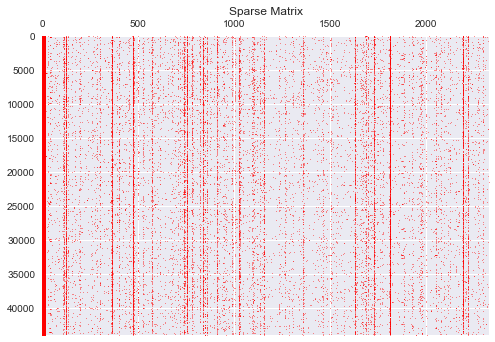

In [19]:
# Sparse matrix of tags
plt.spy(termtag_df, aspect='auto', markersize=.5, c='r')
plt.title("Sparse Matrix");

In [20]:
print(termtag_df.sum().sort_values(ascending=False).head(50))

# Confirm duplicates
termtag_df.reset_index(inplace=True)
print("Row duplicates:", termtag_df.duplicated(subset=['artist_id']).sum())

other                             43194
rock                              30172
electronic                        28484
pop                               24891
hiphop                            17660
jazz                              16640
punk                              16149
funk                              15978
alternative                       15298
metal                             10246
folk                               9894
country                            8352
reggae                             7161
tag_classic pop and rock           1073
tag_american                       1027
tag_uk                             1013
tag_british                         975
tag_rock and indie                  920
tag_rock                            843
tag_english                         670
tag_punk                            636
tag_folk                            603
tag_electronic                      413
tag_german                          387
tag_pop                             384


### <a id="B"></a>Track Metadata & Song Metadata

In [22]:
metadata_df = pd.merge(track_metadata_df, song_metadata_hdf5_df, on='song_id',
                       how='outer', suffixes=('_1', '_2'))

metadata_df.drop(['artist_id_2', 'artist_name_2'],
                  axis=1, inplace=True)

metadata_df.fillna('N/A', inplace=True)
print(metadata_df.isnull().sum())

track_id              0
title                 0
song_id               0
release               0
artist_id_1           0
artist_mbid_1         0
artist_name_1         0
duration              0
artist_familiarity    0
artist_hotttnesss     0
year                  0
artist_latitude       0
artist_longitude      0
artist_mbid_2         0
song_hotttnesss       0
dtype: int64


In [23]:
metadata_df.head(2)

,track_id,title,song_id,release,artist_id_1,artist_mbid_1,artist_name_1,duration,artist_familiarity,artist_hotttnesss,year,artist_latitude,artist_longitude,artist_mbid_2,song_hotttnesss
0,TRMMMYQ128F932D901,Silent Night,SOQMMHC12AB0180CB8,Monster Ballads X-Mas,ARYZTJS1187B98C555,357ff05d-848a-44cf-b608-cb34b5701ae5,Faster Pussy cat,252.05506,0.64982,0.39403,2003,-9999.0,-9999.0,357ff05d-848a-44cf-b608-cb34b5701ae5,0.54290
1,TRMMMKD128F425225D,Tanssi vaan,SOVFVAK12A8C1350D9,Karkuteillä,ARMVN3U1187FB3A1EB,8d7ef530-a6fd-4f8f-b2e2-74aec765e0f9,Karkkiautomaatti,156.55138,0.43960,0.35699,1995,-9999.0,-9999.0,8d7ef530-a6fd-4f8f-b2e2-74aec765e0f9,0.29988


In [24]:
# Explore duplicates
print("Row duplicates: ", metadata_df.duplicated(subset=['song_id']).sum())
metadata_df.sort_values(['song_hotttnesss'], inplace=True, ascending=False)
metadata_df.loc[metadata_df.duplicated(subset=['song_id'], keep=False)].head(4)

Row duplicates:  2928


,track_id,title,song_id,release,artist_id_1,artist_mbid_1,artist_name_1,duration,artist_familiarity,artist_hotttnesss,year,artist_latitude,artist_longitude,artist_mbid_2,song_hotttnesss
254947,TRBUUAF128F92CE5A3,Man In The Box,SODTUOO12A8C14289A,Heavy Metal Palace Vol. 1,ARSW5F51187FB4CFC9,4bd95eea-b9f6-4d70-a36c-cfea77431553,Alice In Chains,284.76036,0.79634,0.57025,1990,-9999.00000,-9999.00000,4bd95eea-b9f6-4d70-a36c-cfea77431553,1.0
10781,TRAWBHE12903CBC4CB,Nothin' On You [feat. Bruno Mars] (Album Version),SOULTKQ12AB018A183,B.o.B Presents: The Adventures of Bobby Ray,ARKQQZA12086C116FC,94c338ff-1985-4429-9dc8-997b61bb5932,B.o.B,269.63546,0.76822,0.71253,2010,38.89910,-77.02900,94c338ff-1985-4429-9dc8-997b61bb5932,1.0
602211,TRSHKBR128F4281C97,Last Nite,SOQFXDQ12AF72AD0EE,Is This It,AR9O98A1187FB39621,f181961b-20f7-459e-89de-920ef03c7ed0,The Strokes,197.53751,0.80704,0.59174,2001,40.71455,-74.00712,f181961b-20f7-459e-89de-920ef03c7ed0,1.0
10780,TRMFRFX12903CD6E4C,Nothin' On You [feat. Bruno Mars] (Album Version),SOULTKQ12AB018A183,Nothin' On You [feat. Bruno Mars],ARKQQZA12086C116FC,94c338ff-1985-4429-9dc8-997b61bb5932,B.o.B,269.63546,0.76822,0.73887,0,38.89910,-77.02900,94c338ff-1985-4429-9dc8-997b61bb5932,1.0


In [25]:
# Get rid of the duplicate entries, capturing the song hotttnesss score if it exists
metadata_df.drop_duplicates(subset=['song_id', 'track_id'], keep=False, inplace=True)
print("Row duplicates: ", metadata_df.duplicated(subset=['song_id']).sum())

Row duplicates:  0


In [26]:
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998160 entries, 69811 to 500992
Data columns (total 15 columns):
track_id              998160 non-null object
title                 998160 non-null object
song_id               998160 non-null object
release               998160 non-null object
artist_id_1           998160 non-null object
artist_mbid_1         998160 non-null object
artist_name_1         998160 non-null object
duration              998160 non-null float64
artist_familiarity    998160 non-null float64
artist_hotttnesss     998160 non-null float64
year                  998160 non-null int64
artist_latitude       998160 non-null float64
artist_longitude      998160 non-null float64
artist_mbid_2         998160 non-null object
song_hotttnesss       998160 non-null float64
dtypes: float64(6), int64(1), object(8)
memory usage: 121.8+ MB


### <a id="C"></a> Metadata & Track Analysis

In [27]:
song_df = pd.merge(metadata_df, track_analysis_df, on='track_id',
                       how='outer', suffixes=('_1', '_2'))

song_df.drop(['duration_2'], axis=1, inplace=True)
song_df.dropna(subset=['song_id'], inplace=True)
song_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998160 entries, 0 to 998159
Data columns (total 24 columns):
track_id                     998160 non-null object
title                        998160 non-null object
song_id                      998160 non-null object
release                      998160 non-null object
artist_id_1                  998160 non-null object
artist_mbid_1                998160 non-null object
artist_name_1                998160 non-null object
duration_1                   998160 non-null float64
artist_familiarity           998160 non-null float64
artist_hotttnesss            998160 non-null float64
year                         998160 non-null float64
artist_latitude              998160 non-null float64
artist_longitude             998160 non-null float64
artist_mbid_2                998160 non-null object
song_hotttnesss              998160 non-null float64
end_of_fade_in               998160 non-null float64
key                          998160 non-null int6

In [28]:
print("Row duplicates: ", song_df.duplicated(subset=['song_id']).sum())
print("Row duplicates: ", song_df.duplicated(subset=['track_id']).sum())

Row duplicates:  0
Row duplicates:  0


### <a id="D"></a> Final Aggregation

In [29]:
df = pd.merge(song_df, termtag_df, left_on='artist_id_1', right_on='artist_id',
                       how='left', suffixes=('_1', '_2'))

df.dropna(subset=['artist_id'], inplace=True)
df.info()

### <a id=7></a> Downcasting

In [31]:
# Split, apply, combine method for optimizing dataframe
# Calculating memory usage function
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.4f} MB".format(usage_mb)


# Downcast ints
df_int = df.select_dtypes(include=['int'])
converted_int = df_int.apply(pd.to_numeric, downcast='unsigned')

print(mem_usage(df_int))
print(mem_usage(converted_int))

compare_ints = pd.concat([df_int.dtypes,converted_int.dtypes],axis=1)
compare_ints.columns = ['before','after']
compare_ints.apply(pd.Series.value_counts)

#df_int.info(memory_usage='deep')
#converted_int.info(memory_usage='deep')

30.3481 MB
10.4322 MB


,before,after
uint8,NaN,3.0
int64,3.0,NaN


In [32]:
# Downcast floats to ints
df_float = df.select_dtypes(include=['float'])
converted_float = df_float.apply(pd.to_numeric, downcast='signed')

print(mem_usage(df_float))
print(mem_usage(converted_float))

compare_floats = pd.concat([df_float.dtypes, converted_float.dtypes],axis=1)
compare_floats.columns = ['before','after']
compare_floats.apply(pd.Series.value_counts)

17761.2516 MB
2307.4074 MB


,before,after
int8,NaN,2327
int16,NaN,1
float64,2340.0,12


In [33]:
# Downcast objects to categoricals
df_obj = df.select_dtypes(include=['object']).copy()
df_obj.describe()

converted_obj = pd.DataFrame()

for col in df_obj.columns:
    num_unique_values = len(df_obj[col].unique())
    num_total_values = len(df_obj[col])
    if num_unique_values / num_total_values < 0.5:
        converted_obj.loc[:,col] = df_obj[col].astype('category')
    else:
        converted_obj.loc[:,col] = df_obj[col]
        
print(mem_usage(df_obj))
print(mem_usage(converted_obj))

compare_obj = pd.concat([df_obj.dtypes,converted_obj.dtypes],axis=1)
compare_obj.columns = ['before','after']
compare_obj.apply(pd.Series.value_counts)

679.9290 MB
288.0169 MB


,before,after
object,9.0,3
category,NaN,2
category,NaN,2
category,NaN,1
category,NaN,1


In [34]:
# Combining the converted dataframe types
optimized_df = pd.DataFrame()

optimized_df[converted_obj.columns] = converted_obj
optimized_df[converted_int.columns] = converted_int
optimized_df[converted_float.columns] = converted_float

print(mem_usage(df))
print(mem_usage(optimized_df))

18456.3547 MB
2590.6824 MB


In [35]:
optimized_df.drop(['artist_id_1', 'release', 'artist_mbid_1', 'artist_mbid_2'],
                  axis=1, inplace=True)
print(optimized_df.columns[:30])

Index(['track_id', 'title', 'song_id', 'artist_name_1', 'artist_id', 'key',
       'mode', 'time_signature', 'duration_1', 'artist_familiarity',
       'artist_hotttnesss', 'year', 'artist_latitude', 'artist_longitude',
       'song_hotttnesss', 'end_of_fade_in', 'loudness', 'mode_confidence',
       'start_of_fade_out', 'tempo', 'time_signature_confidence',
       'alternative', 'country', 'electronic', 'folk', 'funk', 'hiphop',
       'jazz', 'metal', 'other'],
      dtype='object')


In [36]:
model_df = optimized_df.rename(columns={'artist_name_1': 'a_',
                                        'artist_id': 'a_id',
                                        'artist_familiarity': 'a_fam',
                                        'artist_latitude': 'a_lat',
                                        'artist_longitude': 'a_lon',
                                        'artist_hotttnesss': 'a_hot',
                                        'song_hotttnesss': 's_hot',
                                        'title': 's_',
                                        'song_id': 's_id',
                                        'key': 's_key',
                                        'mode': 's_mode',
                                        'year': 's_year',
                                        'duration_1': 's_dur',
                                        'end_of_fade_in': 's_fade_in',
                                        'start_of_fade_out': 's_fade_out',
                                        'tempo': 's_tempo',
                                        'loudness': 's_loud',
                                        'mode_confidence': 's_mode_conf',
                                        'time_signature': 's_tsig',
                                        'time_signature_confidence': 's_ts_conf',
                                        'track_id': 'tr_id'
                                       })

In [37]:
#model_df.isnull().sum()

### <a id=8></a> Pickling

In [ ]:
# Split into 2 DF's for pickle
M1_df = model_df.iloc[:500000,].copy()
M2_df = model_df.iloc[500000:,].copy()

if not os.path.isdir('data/'):
    os.makedirs('data/')
M1_df.to_pickle(path = 'data/model1_df.pickle')
M2_df.to_pickle(path = 'data/model2_df.pickle')